In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
import seaborn as sns
import pickle
sns.set_style("whitegrid")

In [2]:
boxOffice = pickle.load( open( "LeapReallyCleanedBoxofficeData.p", "rb" ) )
multiplierDataFrame = pd.DataFrame(columns=('title', 'Opening Week', 'Opening Week Number', 'Opening Gross', 'Multiplier', 'Total Gross'))
i=0
threshold = 0.6
for title in boxOffice:
    cleanTitle = title.split(' (')[0] # Remove Year Tag
    widestWeek = max(boxOffice[title].Theaters)
    startingWeek = 0
    currentWeek = 0
    startingWeek = boxOffice[title][boxOffice[title].Theaters>=threshold*widestWeek].Week.min()
    # weekCutoffs[cleanTitle] = pd.to_datetime(boxOffice[title].at[startingWeek, 'Date'])
    opening = sum(boxOffice[title].Weekly.iloc[0:startingWeek].values)
    total = sum(boxOffice[title].Weekly.values)
    multiplier = total/opening
    multiplierDataFrame.loc[i] = [cleanTitle, pd.to_datetime(boxOffice[title].at[startingWeek, 'Date']), startingWeek, opening, multiplier, total]
    i+=1
multiplierDataFrame

,title,Opening Week,Opening Week Number,Opening Gross,Multiplier,Total Gross
0,Alien,1979-06-22,5,24778046,2.416036,59864651
1,Raging Bull,1980-12-19,6,1863003,1.000000,1863003
2,Star Wars: Episode V - The Empire Strikes Back,1980-06-20,6,72105828,1.590517,114685535
3,Modern Problems,1981-12-25,1,6797672,3.600396,24474312
4,On Golden Pond,1982-02-12,11,32903892,3.246197,106812502
...,...,...,...,...,...,...
6145,Companion,2025-01-31,1,12467009,1.669133,20809101
6146,Green and Gold,2025-01-31,1,1101232,1.561074,1719105
6147,Den of Thieves: Pantera,2025-01-10,1,19575028,1.839845,36015016
6148,Presence,2025-01-24,1,4543377,1.518704,6900044


In [3]:
# read in review and movie data into data frames
dfs = pd.read_csv('./cleandata/rotten_tomatoes_movie_reviews_clean_scale.csv', index_col=False)
dfm = pd.read_csv('./cleandata/rotten_tomatoes_movies_clean.csv', index_col=False)

rottenMovies = dfm.filter(['id', 'title']) # One line per movie with id, title, and "Release Date"
rottenReviews = dfs.filter(['id', 'creationDate', 'isTopCritic', 'originalScore']) # One line per review with normalized score, etc.
rottenReviews['binaryScore'] = [0 if sS == "NEGATIVE" else 1 for sS in dfs['scoreSentiment']] # Convert sentiment to numerical value

movie_ids_winfo = pd.unique(rottenMovies['id']).tolist() # unique list of movie ids from movie list
mask = rottenReviews['id'].isin(movie_ids_winfo)
rottenReviews = rottenReviews[mask]

movie_ids_wrevs = pd.unique(rottenReviews['id']).tolist()
mask2 = rottenMovies['id'].isin(movie_ids_wrevs)
rottenMovies = rottenMovies[mask2]

rottenMoviesWithMultipliers = rottenMovies.merge(multiplierDataFrame, how='inner', on='title')

rottenMoviesWithMultipliers.head()

,id,title,Opening Week,Opening Week Number,Opening Gross,Multiplier,Total Gross
0,adrift_2018,Adrift,2018-06-01,1,16690016,1.884061,31445011
1,paul_blart_mall_cop,Paul Blart: Mall Cop,2009-01-16,1,43300198,3.379573,146336178
2,not_without_my_daughter,Not Without My Daughter,1991-01-11,1,4962104,2.526219,12535359
3,monsoon_wedding,Monsoon Wedding,2002-04-12,8,6420342,2.162313,13882786
4,rookie_of_the_year,Rookie of the Year,1993-07-09,1,18213869,2.577962,46954670


In [4]:
rottenReviewsWithTitles = rottenReviews.merge(rottenMovies, how='inner', on='id')
rottenReviewsWithOpening = rottenReviewsWithTitles.merge(multiplierDataFrame[['title', 'Opening Week']], how='inner', on='title')
rottenReviewsWithOpening['creationDate'] = pd.to_datetime(rottenReviewsWithOpening['creationDate'])

rottenReviewsWithOpening.head()

,id,creationDate,isTopCritic,originalScore,binaryScore,title,Opening Week
0,addicted_2014,2019-09-06,False,0.200,0,Addicted,2014-10-10
1,addicted_2014,2015-01-09,False,0.000,0,Addicted,2014-10-10
2,addicted_2014,2014-10-16,True,0.425,0,Addicted,2014-10-10
3,addicted_2014,2014-10-11,True,0.375,0,Addicted,2014-10-10
4,addicted_2014,2014-10-10,True,0.300,0,Addicted,2014-10-10


In [5]:
earlyRottenReviews = rottenReviewsWithOpening.loc[rottenReviewsWithOpening['creationDate']<=rottenReviewsWithOpening['Opening Week']]
earlyTopRottenReviews = rottenReviewsWithOpening.loc[(rottenReviewsWithOpening['creationDate']<=rottenReviewsWithOpening['Opening Week']) \
 & (rottenReviewsWithOpening.isTopCritic)]

avgEarlyReviews = earlyRottenReviews.filter(['title', 'originalScore', 'binaryScore', 'Multiplier']).groupby(['title']).mean()
avgEarlyReviewsInfo = avgEarlyReviews.merge(dfm.filter(['genre', 'rating', 'title', 'id']), how='inner', on='title').dropna()

avgEarlyTopReviews = earlyTopRottenReviews.filter(['title', 'originalScore', 'binaryScore', 'Multiplier']).groupby(['title']).mean()
avgEarlyTopReviewsInfo = avgEarlyTopReviews.merge(dfm.filter(['genre', 'rating', 'title', 'id']), how='inner', on='title').dropna()

avgEarlyReviewsInfo.head()

,title,originalScore,binaryScore,genre,rating,id
0,'71,0.779367,0.974684,"Action, Mystery & thriller",R,71_2015
1,10 Cloverfield Lane,0.752895,0.905263,Mystery & thriller,PG-13,10_cloverfield_lane
3,102 Not Out,0.560000,0.600000,Comedy,PG,102_not_out
4,12 Mighty Orphans,0.584677,0.580645,"History, Drama",PG-13,12_mighty_orphans
5,12 Monkeys,0.825000,1.000000,"Mystery & thriller, Sci-fi",R,12_monkeys


In [6]:
avgEarlyTopReviewsInfo.head()

,title,originalScore,binaryScore,genre,rating,id
0,'71,0.782857,0.971429,"Action, Mystery & thriller",R,71_2015
1,10 Cloverfield Lane,0.741216,0.891892,Mystery & thriller,PG-13,10_cloverfield_lane
3,12 Mighty Orphans,0.540000,0.400000,"History, Drama",PG-13,12_mighty_orphans
4,12 Monkeys,0.825000,1.000000,"Mystery & thriller, Sci-fi",R,12_monkeys
5,12 Strong,0.594643,0.607143,"War, Drama",R,12_strong


In [7]:
rottenMoviesFullInfo = rottenMoviesWithMultipliers.merge(avgEarlyReviewsInfo[['title', 'originalScore', 'binaryScore', 'genre', 'rating']], how='inner', on='title')
rottenMoviesFullInfo = rottenMoviesFullInfo.loc[rottenMoviesFullInfo['originalScore']<=1.0]

rottenMoviesFullInfoTC = rottenMoviesWithMultipliers.merge(avgEarlyTopReviewsInfo[['title', 'originalScore', 'binaryScore', 'genre', 'rating']], how='inner', on='title')
rottenMoviesFullInfoTC = rottenMoviesFullInfoTC.loc[rottenMoviesFullInfoTC['originalScore']<=1.0]

rottenMoviesFullInfo.head()

,id,title,Opening Week,Opening Week Number,Opening Gross,Multiplier,Total Gross,originalScore,binaryScore,genre,rating
0,paul_blart_mall_cop,Paul Blart: Mall Cop,2009-01-16,1,43300198,3.379573,146336178,0.483273,0.309091,Comedy,PG
1,monsoon_wedding,Monsoon Wedding,2002-04-12,8,6420342,2.162313,13882786,0.829918,0.967213,"Comedy, Drama",R
2,robin_hood_2018,Robin Hood,2010-05-14,1,47396470,2.221046,105269730,0.574955,0.455331,"Action, Adventure",PG-13
3,robin_hood_2018,Robin Hood,2010-05-14,1,47396470,2.221046,105269730,0.574955,0.455331,"Adventure, Action, History, Drama",PG-13
4,robin_hood_2018,Robin Hood,2018-11-16,1,5102325,6.041291,30824628,0.574955,0.455331,"Action, Adventure",PG-13


In [8]:
rottenMoviesFullInfoTC.head()

,id,title,Opening Week,Opening Week Number,Opening Gross,Multiplier,Total Gross,originalScore,binaryScore,genre,rating
0,paul_blart_mall_cop,Paul Blart: Mall Cop,2009-01-16,1,43300198,3.379573,146336178,0.484783,0.304348,Comedy,PG
1,monsoon_wedding,Monsoon Wedding,2002-04-12,8,6420342,2.162313,13882786,0.837037,1.000000,"Comedy, Drama",R
2,robin_hood_2018,Robin Hood,2010-05-14,1,47396470,2.221046,105269730,0.573469,0.479592,"Action, Adventure",PG-13
3,robin_hood_2018,Robin Hood,2010-05-14,1,47396470,2.221046,105269730,0.573469,0.479592,"Adventure, Action, History, Drama",PG-13
4,robin_hood_2018,Robin Hood,2018-11-16,1,5102325,6.041291,30824628,0.573469,0.479592,"Action, Adventure",PG-13


Text(0, 0.5, 'Total Gross Amount')

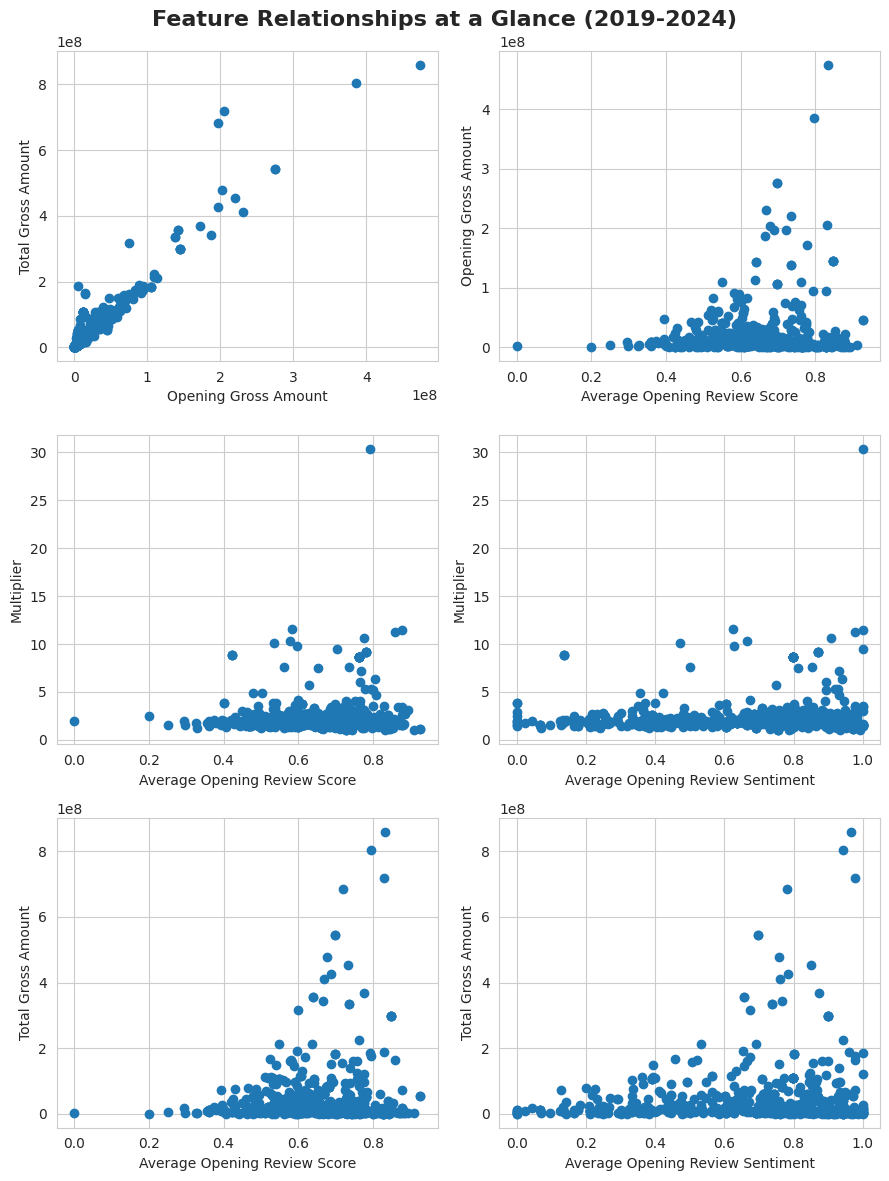

In [9]:
rottenMoviesFullInfoL5Y = rottenMoviesFullInfo.copy()
rottenMoviesFullInfoL5Y['year'] = [str(oD).split('-')[0] for oD in rottenMoviesFullInfoL5Y['Opening Week']]
rottenMoviesFullInfoL5Y = rottenMoviesFullInfoL5Y.loc[rottenMoviesFullInfoL5Y['year'] <= '2024']
rottenMoviesFullInfoL5Y = rottenMoviesFullInfoL5Y.loc[rottenMoviesFullInfoL5Y['year'] >= '2019']

fig, ax = plt.subplots(3, 2, figsize=(9, 12), layout='tight')
fig.suptitle('Feature Relationships at a Glance (2019-2024)', fontweight='bold', fontsize=16)
ax[0,0].scatter(rottenMoviesFullInfoL5Y['Opening Gross'], rottenMoviesFullInfoL5Y['Total Gross'])
ax[0,0].set_xlabel('Opening Gross Amount')
ax[0,0].set_ylabel('Total Gross Amount')
ax[0,1].scatter(rottenMoviesFullInfoL5Y['originalScore'], rottenMoviesFullInfoL5Y['Opening Gross'])
ax[0,1].set_xlabel('Average Opening Review Score')
ax[0,1].set_ylabel('Opening Gross Amount')
ax[1,0].scatter(rottenMoviesFullInfoL5Y['originalScore'], rottenMoviesFullInfoL5Y['Multiplier'])
ax[1,0].set_xlabel('Average Opening Review Score')
ax[1,0].set_ylabel('Multiplier')
ax[1,1].scatter(rottenMoviesFullInfoL5Y['binaryScore'], rottenMoviesFullInfoL5Y['Multiplier'])
ax[1,1].set_xlabel('Average Opening Review Sentiment')
ax[1,1].set_ylabel('Multiplier')
ax[2,0].scatter(rottenMoviesFullInfoL5Y['originalScore'], rottenMoviesFullInfoL5Y['Total Gross'])
ax[2,0].set_xlabel('Average Opening Review Score')
ax[2,0].set_ylabel('Total Gross Amount')
ax[2,1].scatter(rottenMoviesFullInfoL5Y['binaryScore'], rottenMoviesFullInfoL5Y['Total Gross'])
ax[2,1].set_xlabel('Average Opening Review Sentiment')
ax[2,1].set_ylabel('Total Gross Amount')